In [14]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english')) 

### Dataset: Amazon Fine Food Reviews

Amazon Fine Food Reviews dataset contains reviews of fine foods from Amazon. It includes a collection of reviews spanning over many years. Each review includes information such as the product ID, user ID, profile name, helpfulness rating, review text, review summary, and the time of the review. This dataset is commonly used for sentiment analysis, natural language processing tasks, and abstractive text summarization.

In [2]:
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
columns_to_keep = ["Summary", "Text"]
df = df[columns_to_keep]
df.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
print(f"Shape of the data: {df.shape}")

Shape of the data: (568454, 2)


In [5]:
missing_values_count = df.isna().sum()
print(missing_values_count)

Summary    27
Text        0
dtype: int64


In [6]:
# Drop rows with missing values
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [7]:
print(f"Shape of the data: {df.shape}")

Shape of the data: (568427, 2)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568427 entries, 0 to 568426
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  568427 non-null  object
 1   Text     568427 non-null  object
dtypes: object(2)
memory usage: 8.7+ MB


#### Wordcloud on Summary and Text

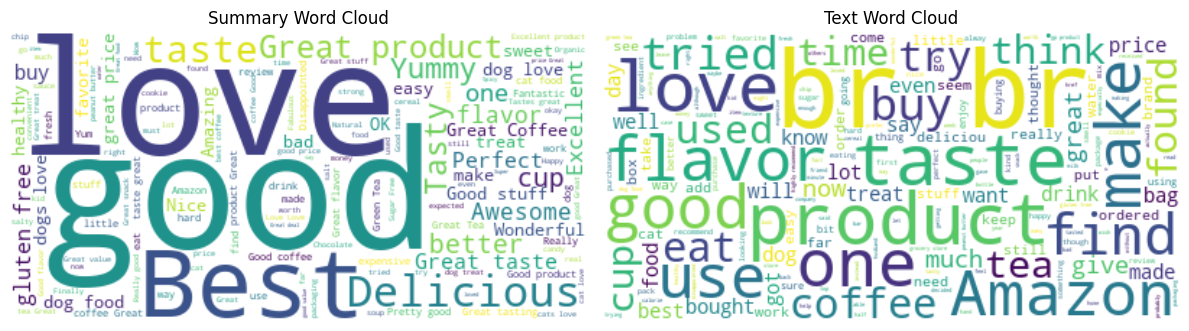

In [9]:
# Function to generate word cloud
def generate_wordcloud(ax, data, title):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(data)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Assuming you have a DataFrame named 'df' with columns 'summary' and 'text'
summary_data = ' '.join(df['Summary'].astype(str))
text_data = ' '.join(df['Text'].astype(str))

# Plotting word clouds using Axes objects
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

generate_wordcloud(axs[0], summary_data, 'Summary Word Cloud')
generate_wordcloud(axs[1], text_data, 'Text Word Cloud')

plt.tight_layout()
plt.show()


#### Text Preprocessing

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"
                      }

def preprocess_text(text):
    ''' clean text column in dataset'''
    # lowercase words
    clean_text = text.lower() 
    # remove HTML tags
    clean_text = BeautifulSoup(clean_text, "lxml").text 
    clean_text = re.sub(r'\([^)]*\)', '', clean_text)
    # remove quotes
    clean_text = re.sub('"', '', clean_text) 
    # the dictionary that we will use for expanding the contractions
    clean_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in clean_text.split(" ")]) 
    # match all strings that contain a non-letter
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text) 
    tokens = [w for w in clean_text.split() if not w in en_stopwords]
     # remove the whitespaces or specific characters from the string at the beginning and end of the string
    clean_text = (" ".join(tokens)).strip()
    return clean_text

# Apply text preprocessing
df['Preprocess_Text'] = df['Text'].copy()
df['Preprocess_Text'] = df['Preprocess_Text'].apply(preprocess_text)
df['Preprocess_Summary'] = df['Summary'].copy()
df['Preprocess_Summary'] = df['Preprocess_Summary'].apply(preprocess_text)
df.head()

C:\Users\smith\AppData\Local\Temp\ipykernel_17964\723412474.py:31: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(clean_text, "lxml").text
C:\Users\smith\AppData\Local\Temp\ipykernel_17964\723412474.py:31: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(clean_text, "lxml").text
C:\Users\smith\AppData\Local\Temp\ipykernel_17964\723412474.py:31: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  clean_text = BeautifulSoup(clean_text, "lxml").text


,Summary,Text,Preprocess_Text,Preprocess_Summary
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,good quality dog food
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,advertised
2,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,delight says
3,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,cough medicine
4,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,great taffy


#### Distribution of the Text and Summary Length

C:\Users\smith\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\smith\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


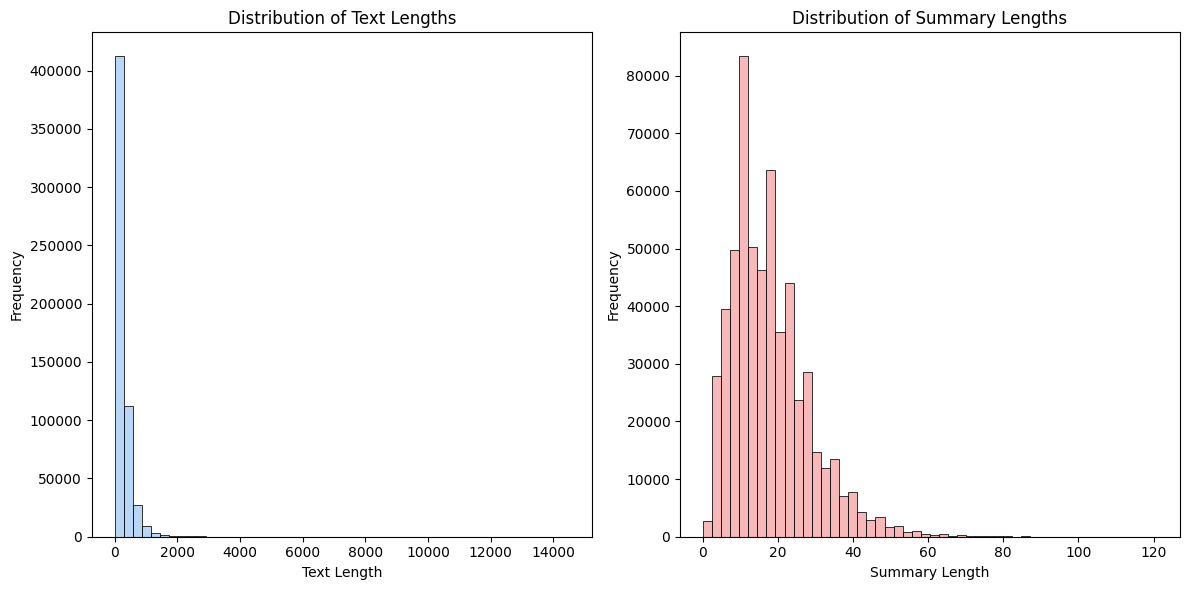

In [13]:
# Calculate the length of each review
df['Text_Length'] = df['Preprocess_Text'].apply(len)
df['Summary_Length'] = df['Preprocess_Summary'].apply(len)

# Plotting the distribution of text lengths and summary lengths side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the distribution of text lengths
sns.histplot(df['Text_Length'], bins=50, color='#a1c9f4', ax=axs[0])
axs[0].set_title('Distribution of Text Lengths')
axs[0].set_xlabel('Text Length')
axs[0].set_ylabel('Frequency')

# Plotting the distribution of summary lengths
sns.histplot(df['Summary_Length'], bins=50, color='#f4a1a1', ax=axs[1])
axs[1].set_title('Distribution of Summary Lengths')
axs[1].set_xlabel('Summary Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Comparision of Text and Summary Length

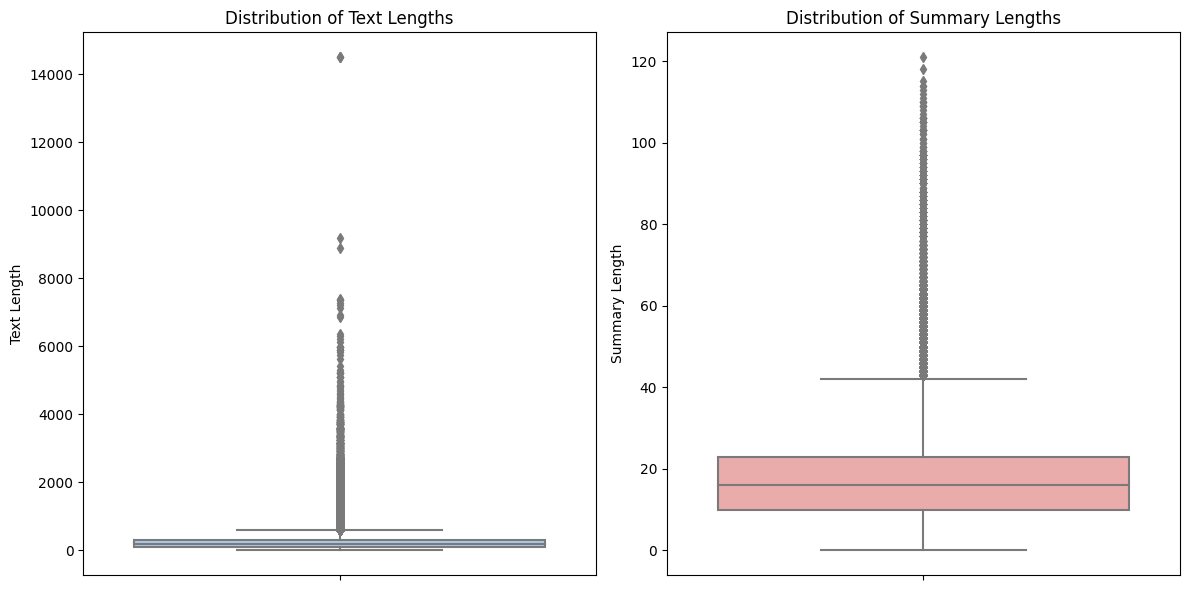

In [16]:
# Plotting the distribution of text lengths and summary lengths side by side using box plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the box plot for text lengths
sns.boxplot(y='Text_Length', data=df, ax=axs[0], color='#a1c9f4')
axs[0].set_title('Distribution of Text Lengths')
axs[0].set_ylabel('Text Length')

# Plotting the box plot for summary lengths
sns.boxplot(y='Summary_Length', data=df, ax=axs[1], color='#f4a1a1')
axs[1].set_title('Distribution of Summary Lengths')
axs[1].set_ylabel('Summary Length')

plt.tight_layout()
plt.show()


#### Most common words from the Text

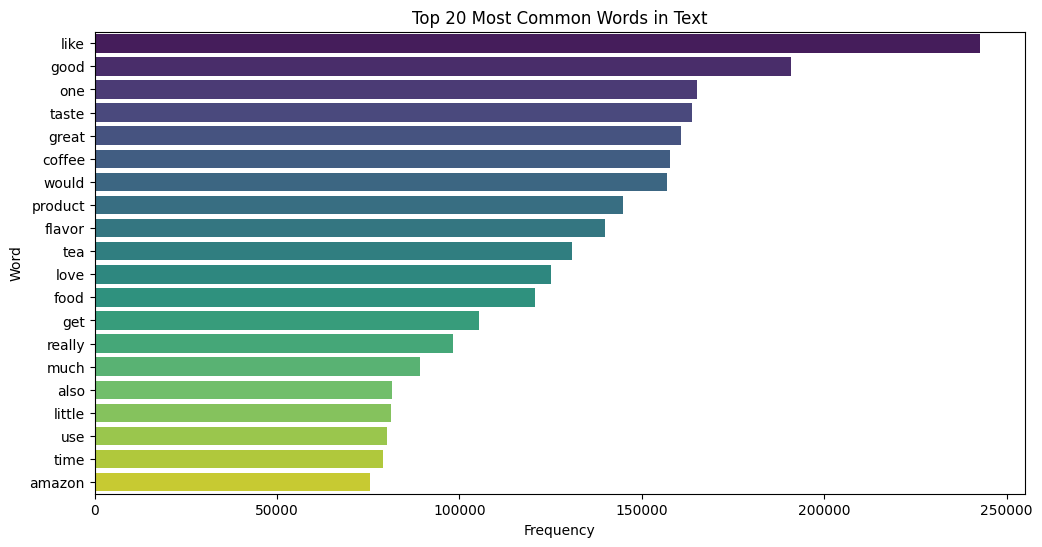

In [15]:
# Concatenate all text data into a single string
all_text = ' '.join(df['Preprocess_Text'])
# Tokenize the text into words
words = all_text.split()
# Count the frequency of each word
word_counts = Counter(words)
# Get the top 20 most common words
top_20_words = word_counts.most_common(20)
# Convert the top words and their frequencies into a DataFrame
top_20_df = pd.DataFrame(top_20_words, columns=['Word', 'Frequency'])

# Plotting the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=top_20_df, palette='viridis')
plt.title('Top 20 Most Common Words in Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()
